===== 交易评分 vs 次日涨跌幅 统计 =====
      次日涨跌幅均值(%)  次日涨跌幅中位数(%)  样本数
交易评分                              
1           0.64         0.03   49
2           0.39         0.29  248
3          -0.10        -0.01  331
4           0.38         0.20  598
5           0.10         0.09  606
6          -0.07        -0.07  457
7           0.07        -0.16  450
8           0.07         0.15  105
9           0.79        -0.02   26
10         -0.48        -0.88    9


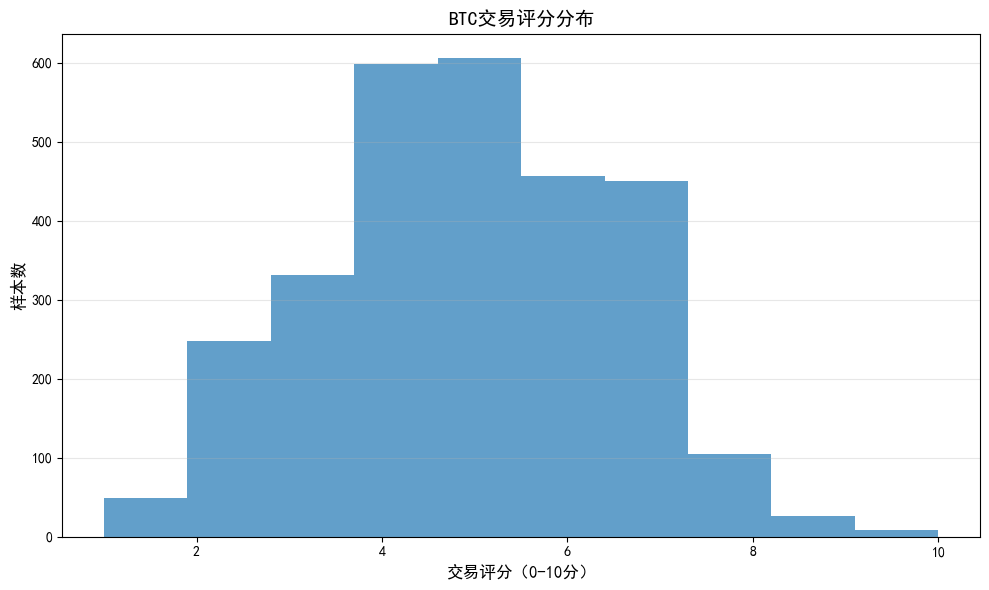

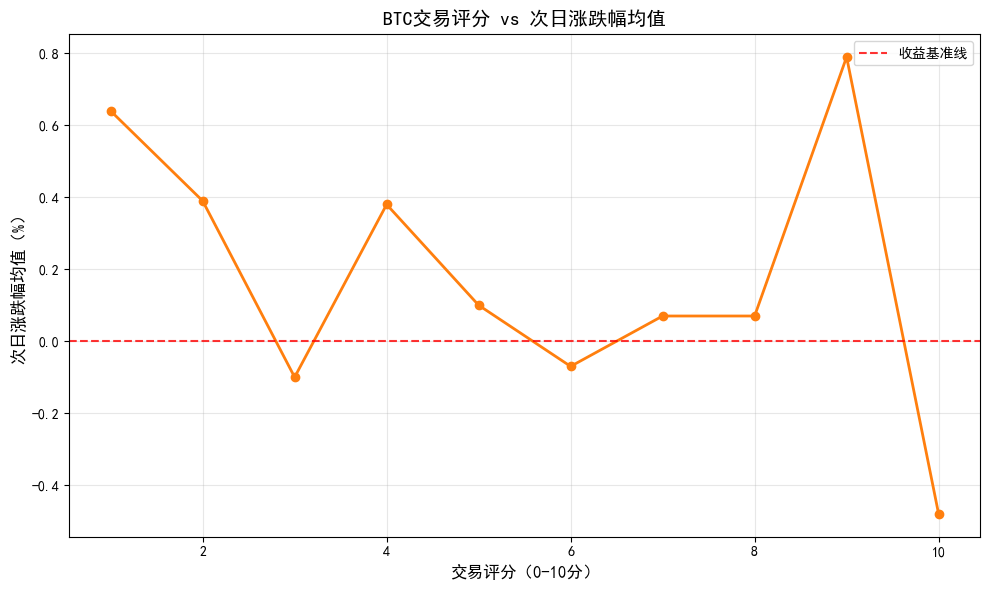


===== 强烈买入信号（评分≥8分） =====
            日期  情绪值           成交量  交易评分  次日涨跌幅（百分比）
68  2018-04-10   18  22326.728095     8        1.61
70  2018-04-12   18  64861.595987    10       -0.58
71  2018-04-13   23  55044.523148     9       -2.23
143 2018-06-27   18  19225.671098     8       -4.56
145 2018-06-29   16  33911.287278     8        3.10
163 2018-07-17   39  52105.423459     9        0.88
164 2018-07-18   42  59487.643450     8        1.14
192 2018-08-15   18  68806.687026     8        0.71
194 2018-08-17   19  57851.610803     8       -2.98
198 2018-08-21   19  41569.947408     8       -1.84

===== 强烈卖出信号（评分≤2分） =====
            日期  情绪值           成交量  交易评分  次日涨跌幅（百分比）
84  2018-04-29   61  38149.850035     2       -1.84
93  2018-05-08   62  25533.831889     2        1.33
95  2018-05-10   63  25055.063718     2       -6.69
385 2019-02-24   69  62224.186890     2        2.25
410 2019-03-21   62  35997.682119     2        0.16
431 2019-04-11   65  54696.600686     2        0.61
433 2019-0

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ========== 1. 读取现有清洗数据 ==========
result_dir = r"C:\Users\33759\Desktop\自选动作 陈正扬 2326010229\结果数据"
data_path = r"C:\Users\33759\Desktop\自选动作 陈正扬 2326010229\修改后数据\BTC_FNG_清洗后数据.xlsx"

df = pd.read_excel(data_path)
df['日期'] = pd.to_datetime(df['日期'])
df = df.sort_values('日期').reset_index(drop=True)

# ========== 2. 前置计算（复用分析方向2的成交量偏离度） ==========
df['成交量_7天均值'] = df['成交量'].rolling(window=7).mean()
df['成交量偏离度(%)'] = (df['成交量'] - df['成交量_7天均值']) / df['成交量_7天均值'] * 100
df['5天涨跌幅'] = df['涨跌幅（百分比）'].rolling(window=5).sum()
df = df.dropna(subset=['成交量偏离度(%)', '5天涨跌幅'])

# ========== 3. 构建多因子评分模型（总分0-10分） ==========
# 因子1：情绪因子（0-4分）→ 恐惧越高分、贪婪越低分
df['情绪因子分'] = np.where(df['情绪值'] < 20, 4,
                        np.where(df['情绪值'] < 40, 3,
                        np.where(df['情绪值'] < 60, 2,
                        np.where(df['情绪值'] < 80, 1, 0))))

# 因子2：成交量因子（0-3分）→ 放量越高分、缩量越低分
df['成交量因子分'] = np.where(df['成交量偏离度(%)'] > 50, 3,
                          np.where(df['成交量偏离度(%)'] < -50, 0, 1))

# 因子3：价格趋势因子（0-3分）→ 5天上涨越高分、下跌越低分
df['趋势因子分'] = np.where(df['5天涨跌幅'] > 0, 3, 0)

# 总评分（0-10分）：越高越适合买入，越低越适合卖出
df['交易评分'] = df['情绪因子分'] + df['成交量因子分'] + df['趋势因子分']

# ========== 4. 评分模型效果验证 ==========
score_stats = df.groupby('交易评分')['次日涨跌幅（百分比）'].agg([
    'mean', 'median', 'count'
]).round(2)
score_stats.columns = ['次日涨跌幅均值(%)', '次日涨跌幅中位数(%)', '样本数']

print("===== 交易评分 vs 次日涨跌幅 统计 =====")
print(score_stats)
# 保存验证结果
score_stats.to_excel(os.path.join(result_dir, "多因子评分_效果验证.xlsx"), engine='openpyxl')

# ========== 5. 可视化：评分分布 + 评分-收益曲线 ==========
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 5.1 交易评分分布直方图
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(df['交易评分'], bins=10, color='#1f77b4', alpha=0.7)
ax1.set_xlabel('交易评分（0-10分）', fontsize=12)
ax1.set_ylabel('样本数', fontsize=12)
ax1.set_title('BTC交易评分分布', fontsize=14)
ax1.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, "多因子评分_分布.png"), dpi=300, bbox_inches='tight')
plt.show()

# 5.2 评分-收益曲线
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(score_stats.index, score_stats['次日涨跌幅均值(%)'], marker='o', color='#ff7f0e', linewidth=2)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8, label='收益基准线')
ax2.set_xlabel('交易评分（0-10分）', fontsize=12)
ax2.set_ylabel('次日涨跌幅均值（%）', fontsize=12)
ax2.set_title('BTC交易评分 vs 次日涨跌幅均值', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, "多因子评分_收益曲线.png"), dpi=300, bbox_inches='tight')
plt.show()

# ========== 6. 实战交易信号输出 ==========
# 筛选高/低评分信号（≥8分=强烈买入，≤2分=强烈卖出）
buy_signals = df[df['交易评分'] >= 8][['日期', '情绪值', '成交量', '交易评分', '次日涨跌幅（百分比）']]
sell_signals = df[df['交易评分'] <= 2][['日期', '情绪值', '成交量', '交易评分', '次日涨跌幅（百分比）']]

print("\n===== 强烈买入信号（评分≥8分） =====")
print(buy_signals.head(10))
print("\n===== 强烈卖出信号（评分≤2分） =====")
print(sell_signals.head(10))

# 保存交易信号
with pd.ExcelWriter(os.path.join(result_dir, "多因子评分_交易信号.xlsx"), engine='openpyxl') as writer:
    buy_signals.to_excel(writer, sheet_name='买入信号', index=False)
    sell_signals.to_excel(writer, sheet_name='卖出信号', index=False)


            日期  情绪值           成交量  交易评分  次日涨跌幅（百分比）
84  2018-04-29   61  38149.850035     2       -1.84
93  2018-05-08   62  25533.831889     2        1.33
95  2018-05-10   63  25055.063718     2       -6.69
385 2019-02-24   69  62224.186890     2        2.25
410 2019-03-21   62  35997.682119     2        0.16
431 2019-04-11   65  54696.600686     2        0.61
433 2019-04-13   62  17292.456802     1        1.71
435 2019-04-15   60  29057.191581     2        2.96
447 2019-04-27   42  15422.896935     2        0.22
448 2019-04-28   40  14371.433869     2       -1.31